In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import json
import os


### transformation and train and test set

In [91]:
transform={
    'train':transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        ]
    ),
    'test':transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        ]
    )
}

### loading dataset with dataloaders

In [92]:
train_dataset=datasets.ImageFolder(root="/home/workstation-p/Downloads/Projects/NLP-MLOPS/Dataset/dataset/train",transform=transform['train'])
val_dataset=datasets.ImageFolder(root="/home/workstation-p/Downloads/Projects/NLP-MLOPS/Dataset/dataset/test",transform=transform['test'])
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

### Pretrained Model Loading

In [93]:
model=models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad=False
num_features=model.classifier[6].in_features
model.classifier[6]=nn.Linear(num_features,len(train_dataset.classes))

/home/workstation-p/anaconda3/envs/conda-env-3-12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/workstation-p/anaconda3/envs/conda-env-3-12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Setting up the loss and optimizer

In [94]:
from torchsummary import summary

In [95]:
criterion=nn.CrossEntropyLoss()
lr=0.001
optimizer=optim.Adam(model.classifier[6].parameters(),lr)
device=torch.device("cuda" if torch.cuda.is_available else "cpu")
print("Device",device)
model.to(device)
summary(model,input_size=(3,224,224))

Device cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14       

### Define the training loop with validation

In [104]:
def train_model(model,train_loader,val_loader,criterion,optimizer,epochs=2):
    train_losses,val_losses,val_accuracies=[],[],[]
    best_accuracy=0.0

    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        train_losses.append(running_loss/len(train_loader))
        model.eval()
        val_loss=0.0
        correct,total=0,0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _,predicted=torch.max(outputs,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
        val_losses.append(val_loss/len(val_loader))
        val_accuracy=correct/total
        val_accuracies.append(val_accuracy)
        if (epoch+1)%10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_accuracy>best_accuracy:
            best_accuracy=val_accuracy
            torch.save(model.state_dict(),'best_model_pytorch_12.pkl')
    
    return train_losses,val_losses,val_accuracies


### Start training

In [105]:
result=train_model(model,train_loader,val_loader,criterion,optimizer,100    )

Epoch 10/100, Train Loss: 0.1617, Val Loss: 0.1852, Val Acc: 0.9231
Epoch 20/100, Train Loss: 0.1636, Val Loss: 0.1781, Val Acc: 0.9231
Epoch 30/100, Train Loss: 0.1447, Val Loss: 0.2162, Val Acc: 0.9066
Epoch 40/100, Train Loss: 0.1579, Val Loss: 0.2287, Val Acc: 0.9066
Epoch 50/100, Train Loss: 0.1743, Val Loss: 0.2016, Val Acc: 0.9286
Epoch 60/100, Train Loss: 0.1537, Val Loss: 0.2133, Val Acc: 0.9176
Epoch 70/100, Train Loss: 0.1969, Val Loss: 0.2370, Val Acc: 0.9066
Epoch 80/100, Train Loss: 0.1607, Val Loss: 0.2108, Val Acc: 0.9121
Epoch 90/100, Train Loss: 0.1506, Val Loss: 0.2409, Val Acc: 0.9121
Epoch 100/100, Train Loss: 0.1393, Val Loss: 0.2127, Val Acc: 0.9176


In [106]:
print(len(result))

3


In [107]:
print(type(result))

<class 'tuple'>


In [108]:
train_losses=result[0]
val_losses=result[1]
val_accuracies=result[2]


In [109]:
for val in result:
    print(val)

[0.19146303655579686, 0.20159688526764513, 0.1678038565441966, 0.18090708134695888, 0.18318458404392005, 0.16302536400035023, 0.18479587510228157, 0.17442798358388245, 0.17380042746663094, 0.16168187726289035, 0.15956726893782616, 0.15405696611851455, 0.17128376075997948, 0.13617219422012566, 0.13769952561706306, 0.14318988751620054, 0.15099319410510362, 0.15940323849208654, 0.14043016862124205, 0.16359077191445975, 0.15124339405447246, 0.13803601274266838, 0.15527366087771952, 0.17630047793500125, 0.17540983557701112, 0.14929038807749748, 0.16350938780233265, 0.15889218775555491, 0.1348758959211409, 0.14470327279996126, 0.14548961604014038, 0.1376134510152042, 0.14376512600574642, 0.16237853856291623, 0.1262462684768252, 0.13557029399089515, 0.14766135897953064, 0.14482913548126816, 0.15198226259090006, 0.15792607003822923, 0.12663110340945422, 0.12749528670683502, 0.1365884585538879, 0.1493964733905159, 0.15560548757202924, 0.16636877092532815, 0.15309366064611823, 0.154869837424485,

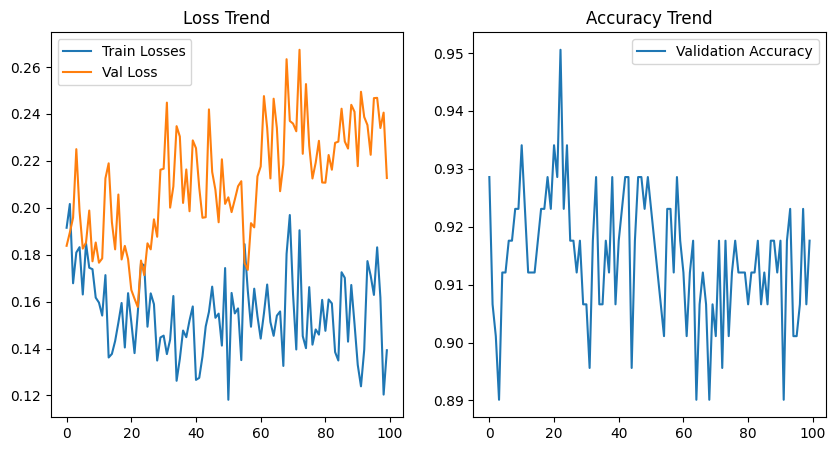

In [110]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label="Train Losses")
plt.plot(val_losses,label="Val Loss")
plt.legend()
plt.title("Loss Trend")
plt.subplot(1,2,2)
plt.plot(val_accuracies,label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Trend")
plt.show()

### Load the trained model and evaluate

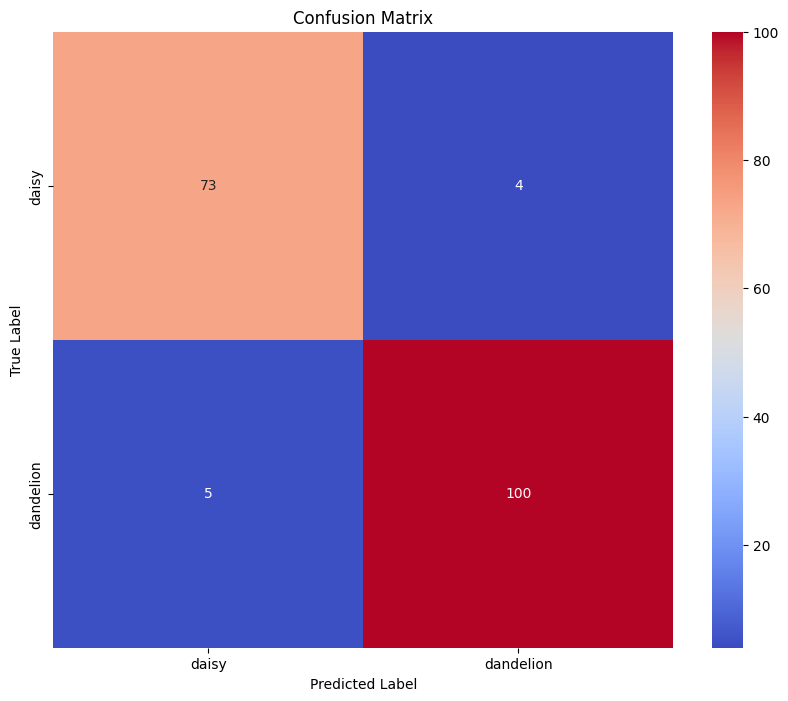

In [112]:
model.load_state_dict(torch.load('best_model_pytorch_12.pkl'))
model.eval()

def plot_confusion_matrix(model,dataloader):
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    all_preds,all_labels=[],[]
    with torch.no_grad():
        for images,labels in dataloader:
            images,labesl=images.to(device),labels.to(device)
            outputs=model(images)
            _,preds=torch.max(outputs,1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        cm=confusion_matrix(all_labels,all_preds)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm,annot=True,fmt="d",cmap="coolwarm",xticklabels=train_dataset.classes,yticklabels=train_dataset.classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

plot_confusion_matrix(model,val_loader)

### Model Inferencing

In [117]:
def infer(image_path,model):
    image=Image.open(image_path).convert('RGB')
    image=transform['test'](image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output=model(image)
    probabilities=torch.nn.functional.softmax(output[0],dim=0)
    k=min(5,probabilities.size(0))
    top5_prob,top5_catid=probabilities.topk(k)
    results=[(train_dataset.classes[catid],prob.item()) for catid,prob in zip(top5_catid,top5_prob)]
    return results

In [118]:
from PIL import Image
def show_image(image_path):
    image=Image.open(image_path)
    plt.imshow(image)
    plt.show()

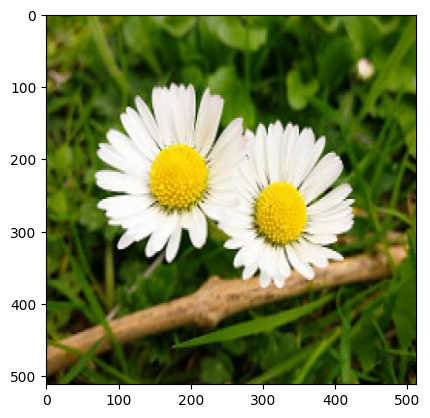

daisy:1.0000
dandelion:0.0000


In [119]:
image_path="/home/workstation-p/Downloads/Projects/NLP-MLOPS/Dataset/dataset/test/daisy/"+"33874126263_3f6f965784_n_jpg.rf.140df6339c7cfdd085f75b7ab7b802f4.jpg"
show_image(image_path)
results=infer(image_path,model)
for label,prob in results:
    print(f"{label}:{prob:.4f}")